In [2]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs

In [3]:
#for_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_June_28_2022\SAR_CPLX_20220517T093239_13.5G_VV_33_pres_1_fdc_auto.sar_INF_SAR_CPLX_20220517T093239_13.5G_VV_34_pres_1_fdc_auto.sar.nc"
#aft_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_June_28_2022\SAR_CPLX_20220517T093239_13.5G_VV_77_pres_1_fdc_auto.sar_INF_SAR_CPLX_20220517T093239_13.5G_VV_78_pres_1_fdc_auto.sar.nc"

for_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Oct_13_2022\SAR_CPLX_20220517T093239_13.5G_VV_33_pres_1_fdc_auto.sar.sig_INF_SAR_CPLX_20220517T093239_13.5G_VV_34_pres_1_fdc_auto.sar.sig.oph.nc"
aft_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Oct_13_2022\SAR_CPLX_20220517T093239_13.5G_VV_77_pres_1_fdc_auto.sar.sig_INF_SAR_CPLX_20220517T093239_13.5G_VV_78_pres_1_fdc_auto.sar.sig.oph.nc"

dsf = xr.open_dataset(for_file, mask_and_scale=True,drop_variables='GBPGridInfo')
dsa = xr.open_dataset(aft_file, mask_and_scale=True,drop_variables='GBPGridInfo')


#mid_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_June_28_2022\SAR_CPLX_20220517T093239_13.5G_VV_00_pres_1_fdc_auto.sar.nc"
mid_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Oct_13_2022\SAR_CPLX_20220517T093239_13.5G_VV_00_pres_1_fdc_auto.sar.sig.nc"

dsm = xr.open_dataset(mid_file, mask_and_scale=True,drop_variables='GBPGridInfo')


In [4]:
# L1 OSCAR processing  


# Compute Fore antenna L1 variables
dsf = ss.oscar.level1.compute_multilooking_Master_Slave(dsf, window=7)
dsf = ss.oscar.level1.add_antenna_baseline(dsf, baseline=0.2)
dsf = ss.oscar.level1.compute_antenna_azimuth_direction(dsf, antenna='fore')
dsf = ss.oscar.level1.compute_time_lag_Master_Slave(dsf, options='from_SAR_time')
dsf = ss.oscar.level1.compute_radial_surface_velocity(dsf)

# Compute Aft antenna L1 variables
dsa = ss.oscar.level1.compute_multilooking_Master_Slave(dsa, window=7)
dsa = ss.oscar.level1.add_antenna_baseline(dsa, baseline=0.2)
dsa = ss.oscar.level1.compute_antenna_azimuth_direction(dsa, antenna='aft')
dsa = ss.oscar.level1.compute_time_lag_Master_Slave(dsa, options='from_SAR_time')
dsa = ss.oscar.level1.compute_radial_surface_velocity(dsa)

# Build Level1 dataset
dsl1 = ss.oscar.level1.init_level1_dataset(dsf, dsa, dsm)

# Initialise level2 dataset
dsl2=ss.oscar.level1.init_level2(dsf, dsa)

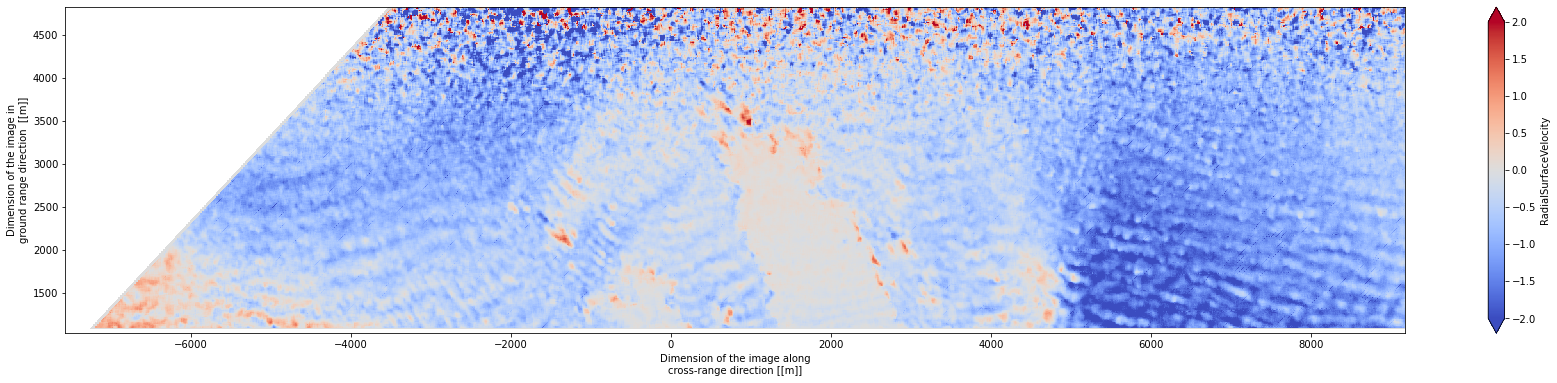

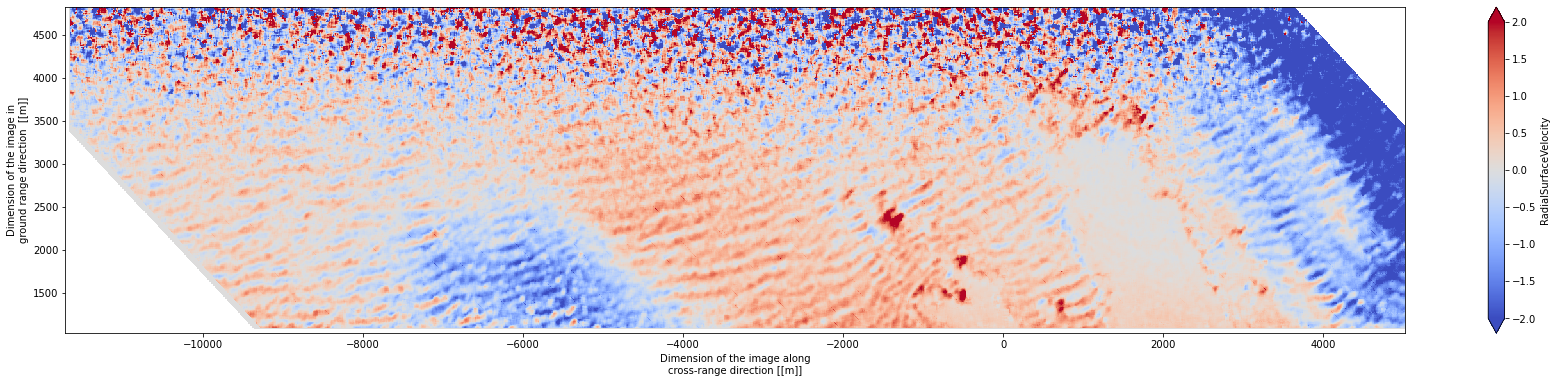

In [5]:
ax1 = dsf.RadialSurfaceVelocity.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',
                                                        vmin=-2,vmax=2
                      )
ax2 = dsa.RadialSurfaceVelocity.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',
                                                        vmin=-2,vmax=2
                      )

In [6]:
# Generating geophysical data fields for GMF doppler computation
u10 = 10 # wind speed
wind_direction = 20 # wind direction
aux = ss.oscar.level1.init_auxiliary(dsl1,dsa,dsf,u10=10,wind_direction=20)



In [ ]:
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    """
    Compute radial surface current (RSC).

    Compute radial surface current (RSC) from radial surface velocity (RSV)
    and the wind artifact surface velocity (WASV) from:
        RSC = RSV - WASV

    Parameters
    ----------
    level1 : xarray.Dataset
        L1 dataset
    aux : xarray.Dataset
        Dataset containing geophysical wind data
    gmf : str, optional
        Choice of geophysical model function to compute the WASV.
        The default is 'mouche12'.

    Returns
    -------
    level2 : xarray.Dataset
        L2 dataset

    """
    
    dswasv_f = seastar.gmfs.doppler.compute_wasv(level1.sel(Antenna='Fore'),
                                                 aux,
                                                 gmf)
    dswasv_a  = seastar.gmfs.doppler.compute_wasv(level1.sel(Antenna='Aft'),
                                                 aux,
                                                 gmf)
    level1['RadialSurfaceCurrent'] = xr.concat(
        [level1.RadialSurfaceVelocity.sel(Antenna='Fore') - dswasv_f.WASV,
         level1.RadialSurfaceVelocity.sel(Antenna='Aft') - dswasv_a.WASV],
        'Antenna', join='inner')
    level1['RadialSurfaceCurrent'] = level1.RadialSurfaceCurrent.assign_coords(
        Antenna=('Antenna', ['Fore', 'Aft']))

    return level1

In [7]:
# L2 OSCAR processing
 
dsl2 = seastar.retrieval.level2.compute_radial_surface_current(dsl1, dsl2, aux, gmf='mouche12')
#dsl1 = compute_radial_surface_current(dsl1, aux, gmf='mouche12')
#level2 = compute_current_magnitude_and_direction(level2, dsf, dsa)
#level2

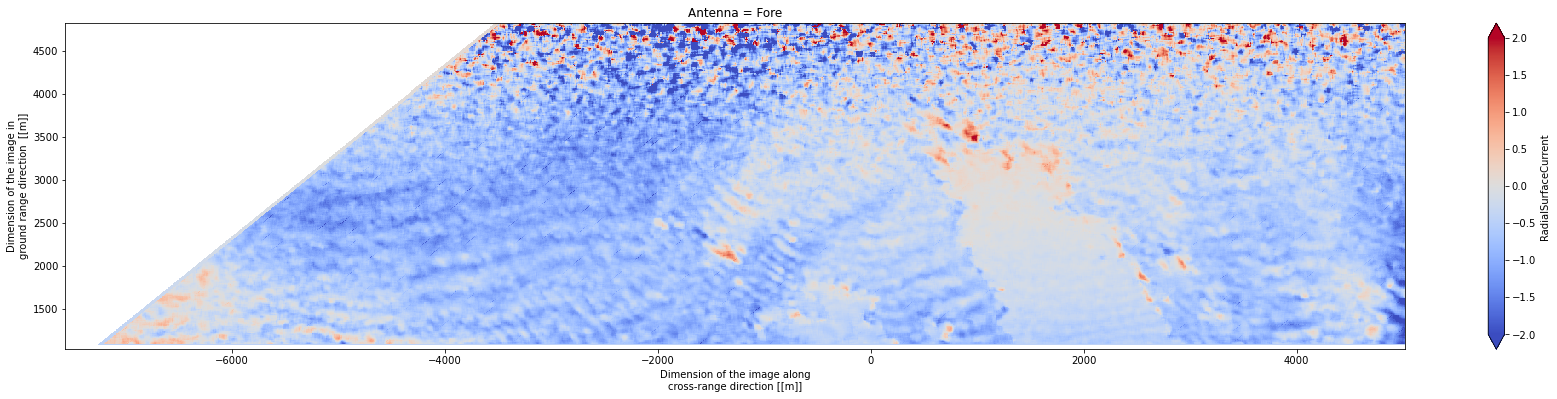

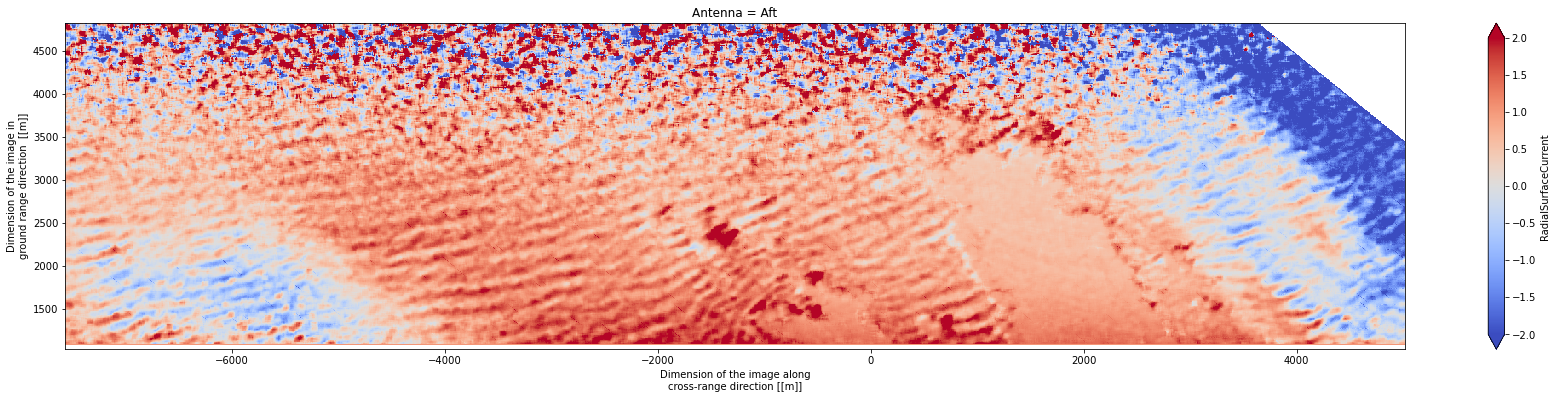

In [8]:
ax3 = dsl2.RadialSurfaceCurrent.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True, 
                                                         cmap='coolwarm',
                                                         vmin=-2,vmax=2
                      )
ax4 = dsl2.RadialSurfaceCurrent.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True, 
                                                        cmap='coolwarm',
                                                        vmin=-2,vmax=2
                                                       )

#vector_density=30
#ax4=plt.quiver(Y[::vector_density, ::vector_density],
#               X[::vector_density, ::vector_density],
#               level2.CurrentVectorUComponent[::vector_density, ::vector_density],
#               level2.CurrentVectorVComponent[::vector_density, ::vector_density])


In [9]:
dsl2=seastar.retrieval.level2.compute_current_magnitude_and_direction(dsl1, dsl2)

(2091, 474)

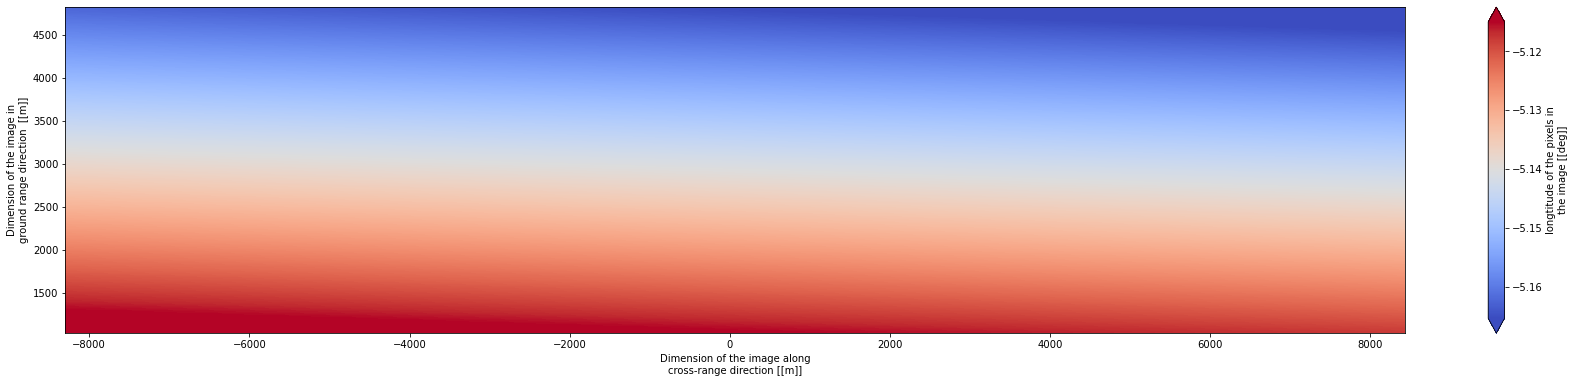

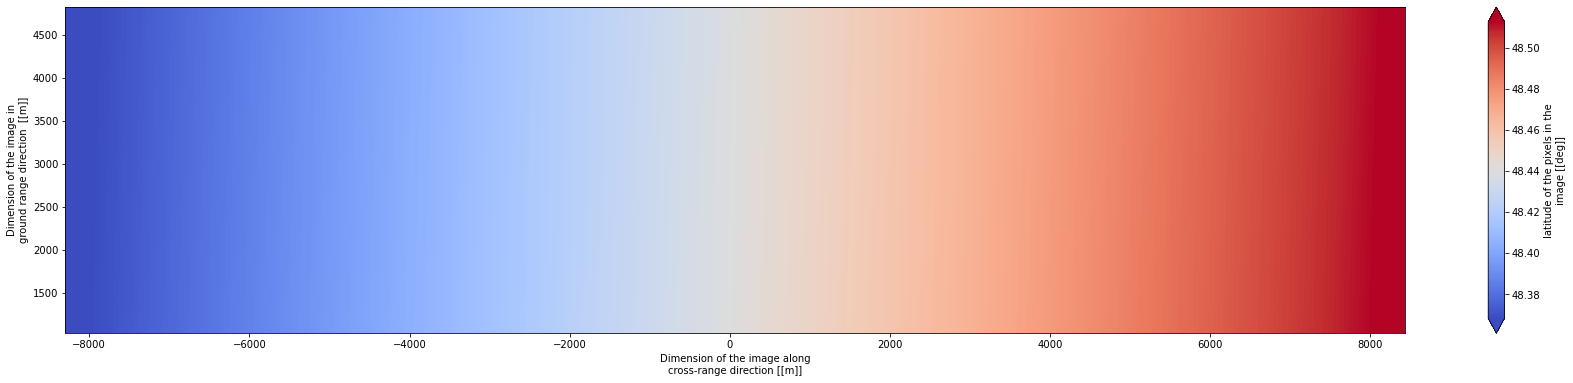

In [10]:
ax3 = dsm.LonImage.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True, 
                                                         cmap='coolwarm',
                       )
ax4 = dsm.LatImage.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True, 
                                                         cmap='coolwarm',
                       )
dsm.LonImage.shape

In [12]:



dsl2.coords['LonImage']=dsm.LonImage
dsl2.coords['LatImage']=dsm.LatImage



(1572, 474)

In [13]:
dsl2.LonImage

<xarray.DataArray 'LonImage' (CrossRange: 1572, GroundRange: 474)>
[745128 values with dtype=float64]
Coordinates:
  * CrossRange   (CrossRange) float64 -7.56e+03 -7.552e+03 ... 5e+03 5.008e+03
  * GroundRange  (GroundRange) float32 1.04e+03 1.048e+03 ... 4.824e+03
    LonImage     (CrossRange, GroundRange) float64 ...
    LatImage     (CrossRange, GroundRange) float64 ...
Attributes:
    long_name:  longtitude of the pixels in the image
    units:      [deg]

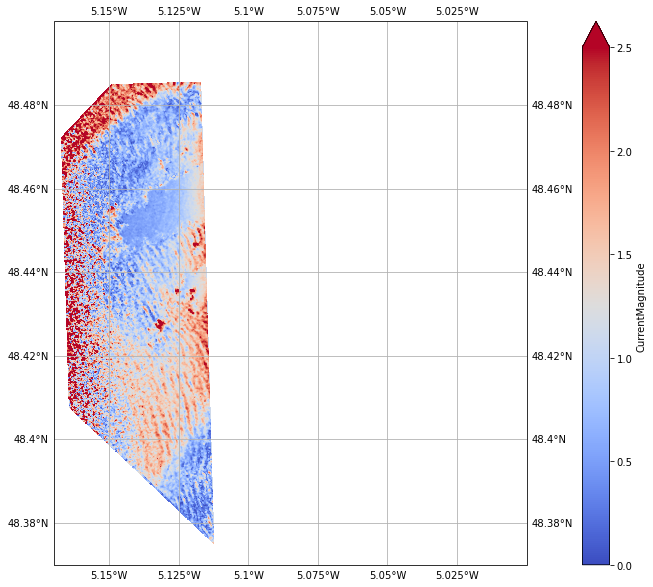

In [18]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2.CurrentMagnitude.plot(
                                 y='LatImage', x='LonImage',
                                 robust=True, 
                                 cmap='coolwarm',
                                 vmin=0, vmax=2.5,
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5., 48.37, 48.5], crs=ccrs.PlateCarree())

In [15]:
def compute_current_vectors(level2):
    
    level2['CurrentVectorUComponent']=level2.CurrentMagnitude *-np.cos(np.radians(level2.CurrentDirection+90))
    level2['CurrentVectorVComponent']=level2.CurrentMagnitude *np.sin(np.radians(level2.CurrentDirection+90))
    
    return level2

In [16]:
dsl2 = compute_current_vectors(dsl2)

In [ ]:
vector_density=30
X, Y = np.meshgrid(dsl2.CrossRange, dsl2.GroundRange, indexing='ij')
ax2 = dsl2.CurrentDirection.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='hsv',
                                                       # vmin=0,vmax=2.5
                      )
plt.quiver(X[::vector_density, ::vector_density],
               Y[::vector_density, ::vector_density],
               dsl2.CurrentVectorUComponent[::vector_density, ::vector_density],
               dsl2.CurrentVectorVComponent[::vector_density, ::vector_density])

In [97]:
dsl2

<xarray.Dataset>
Dimensions:                  (CrossRange: 1572, GroundRange: 474, Antenna: 2)
Coordinates:
  * CrossRange               (CrossRange) float64 -7.56e+03 ... 5.008e+03
  * GroundRange              (GroundRange) float32 1.04e+03 ... 4.824e+03
  * Antenna                  (Antenna) <U4 'Fore' 'Aft'
    LonImage                 (CrossRange, GroundRange) float64 ...
    LatImage                 (CrossRange, GroundRange) float64 ...
Data variables:
    RadialSurfaceCurrent     (Antenna, CrossRange, GroundRange) float64 nan ....
    CurrentMagnitude         (CrossRange, GroundRange) float64 nan nan ... nan
    CurrentDirection         (CrossRange, GroundRange) float64 nan nan ... nan
    CurrentVectorUComponent  (CrossRange, GroundRange) float64 nan nan ... nan
    CurrentVectorVComponent  (CrossRange, GroundRange) float64 nan nan ... nan

In [96]:
dsl2.reset_coords('CrossRange',drop=True)

ValueError: cannot remove index coordinates with reset_coords: {'CrossRange'}

In [60]:
a=np.array([1,2,3])
a.shape

(3,)

In [103]:
x_band_file="D:\data\SEASTAR\SEASTARex\Data\Hereon\Xband_radar_17th_may.mat"
ds_xband=loadmat(x_band_file)
U_xband=ds_xband['Ux']
V_xband=ds_xband['Uy']
lat_xband=ds_xband['latitude']
lon_xband=ds_xband['longitude']
U_xband=xr.DataArray(data=np.ravel(ds_xband['Ux']),
                     dims=['x'],
                     coords={'LonImage':('x',np.ravel(ds_xband['longitude'])),
                             'LatImage':('x',np.ravel(ds_xband['latitude']))}
)



U_xband.interp(coords={'LatImage':(dsl2.LatImage),'LonImage':(dsl2.LatImage)})


ValueError: Dimensions {'LonImage', 'LatImage'} do not exist. Expected one or more of Frozen({'x': 518})

In [98]:
U_xband.interp_like(dsl2.CurrentMagnitude)

<xarray.DataArray (x: 518)>
array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan, -0.24, -0.4 , -0.4 , -0.55,
       -0.37, -0.64,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan, -0.37, -0.2 , -0.37, -0.44, -0.45, -0.4 , -0.54, -0.62,
       -0.55,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
       -0.18, -0.24, -0.17, -0.22, -0.28, -0.35, -0.28, -0.38, -0.37,
       -0.44, -0.5 , -0.6 ,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan, -0.34, -0.33, -0.42, -0.27, -0.35,
       -0.33, -0.27, -0.31, -0.19, -0.42, -0.55, -0.64, -0.9 , -0.98,
         nan,   nan,   nan,   nan,   nan,   nan,   nan, -0.22, -0.35,
       -0.24, -0.3 , -0.39, -0.44, -0.37, -0.28, -0.26, -0.19, -0.28,
       -0.22, -0.46, -0.59, -0.85, -1.09,   nan,   nan,   nan,   nan,
       -0.01, -0.08, -0.21, -0.4 , -0.35, -0.37, -0.34, -0.38, -0.44,
       -0.3 , -0.22, -0.25, -0.1 , -0.06, -0.02, -0.01, -0.24, -0.62,
         nan,   nan,   nan,   nan, -0.06, -0.23, -0.28, -0.38, -0.37,
       -0.4 , -0.43, -0.48, -0.43, -0.3 , -0.22, -0.13, -0.06,  0.05,
        0.03, -0.01, -0.17,   nan,   nan,   nan,   nan, -0.13, -0.27,
       -0.32, -0.33, -0.39, -0.51, -0.43, -0.5 , -0.53, -0.44, -0.28,
       -0.22, -0.15, -0.1 , -0.02, -0.02,  0.08,   nan,   nan,   nan,
         nan,   nan, -0.32, -0.37, -0.44, -0.44, -0.47, -0.58, -0.53,
...
       -0.79, -0.71, -0.69, -0.54, -0.53, -0.47, -0.45, -0.18, -0.18,
         nan,   nan,   nan,   nan, -0.67, -0.72, -0.68, -0.73, -0.68,
       -0.65, -0.5 , -0.45, -0.41, -0.24, -0.16, -0.08,   nan,   nan,
         nan,   nan,   nan,   nan, -0.73, -0.72, -0.71, -0.53, -0.47,
       -0.45, -0.31, -0.16, -0.1 , -0.09, -0.09, -0.11,   nan,   nan,
         nan,   nan, -0.68, -0.72, -0.67, -0.48, -0.43, -0.33, -0.18,
       -0.21, -0.09, -0.09, -0.08, -0.08,   nan,   nan,   nan,   nan,
         nan,   nan, -0.6 , -0.47, -0.43, -0.32, -0.15, -0.18, -0.22,
       -0.17, -0.16, -0.01, -0.11, -0.25, -0.28,   nan,   nan,   nan,
         nan,   nan, -0.41, -0.36, -0.21, -0.15, -0.26, -0.23, -0.1 ,
       -0.07, -0.09, -0.09, -0.24, -0.25, -0.22,   nan,   nan,   nan,
       -0.39, -0.37, -0.25, -0.27, -0.21, -0.19, -0.13, -0.12, -0.1 ,
         nan,   nan, -0.18, -0.08,   nan,   nan,   nan,   nan,   nan,
         nan, -0.23,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan])
Coordinates:
    LonImage  (x) float64 -5.143 -5.14 -5.138 -5.135 ... -5.124 -5.121 -5.118
    LatImage  (x) float64 48.4 48.4 48.4 48.4 48.4 ... 48.45 48.45 48.45 48.45
Dimensions without coordinates: x

ValueError: Cannot specify both x and y kwargs for line plots.

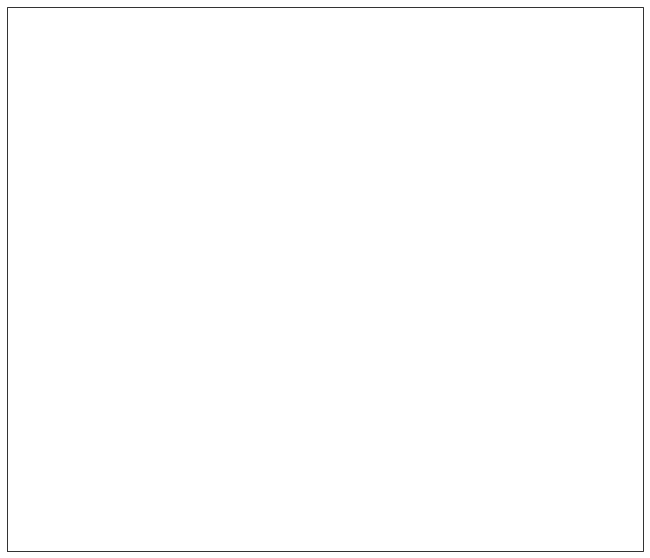

In [47]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
U_xband.plot(
                                 y='LatImage', x='LonImage',
                                 robust=True, 
                                 cmap='coolwarm',
                                 vmin=0, vmax=2.5,
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5., 48.37, 48.5], crs=ccrs.PlateCarree())